In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# Carregando o dataset
df = pd.read_csv('./dataset/train.csv')
df.head()

,Patient Id,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Patient First Name,Family Name,Father's name,...,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,PID0x6418,2.0,Yes,No,Yes,No,4.760603,Richard,NaN,Larre,...,NaN,9.857562,NaN,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,PID0x25d5,4.0,Yes,Yes,No,No,4.910669,Mike,NaN,Brycen,...,Multiple,5.522560,normal,1.0,NaN,1.0,1.0,0.0,NaN,Cystic fibrosis
2,PID0x4a82,6.0,Yes,No,No,No,4.893297,Kimberly,NaN,Nashon,...,Singular,NaN,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,PID0x4ac8,12.0,Yes,No,Yes,No,4.705280,Jeffery,Hoelscher,Aayaan,...,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,PID0x1bf7,11.0,Yes,No,NaN,Yes,4.720703,Johanna,Stutzman,Suave,...,Multiple,4.098210,NaN,0.0,0.0,0.0,0.0,NaN,Multifactorial genetic inheritance disorders,Cancer


In [3]:
# Análise descritiva do dataset
df.describe()

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,White Blood cell count (thousand per microliter),Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5
count,20656.000000,22083.000000,16047.000000,16097.000000,19956.0,19931.0,19936.0,19943.0,19913.0,19921.000000,19935.000000,19928.000000,19861.000000,19982.000000,19970.000000,19930.000000
mean,6.974148,4.898871,34.526454,41.972852,0.0,0.0,0.0,1.0,0.0,2.003062,7.486224,0.592483,0.551886,0.536233,0.497747,0.461917
std,4.319475,0.199663,9.852598,13.035501,0.0,0.0,0.0,0.0,0.0,1.411919,2.653393,0.491385,0.497313,0.498698,0.500007,0.498560
min,0.000000,4.092727,18.000000,20.000000,0.0,0.0,0.0,1.0,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.763109,26.000000,31.000000,0.0,0.0,0.0,1.0,0.0,1.000000,5.424703,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,4.899399,35.000000,42.000000,0.0,0.0,0.0,1.0,0.0,2.000000,7.477132,1.000000,1.000000,1.000000,0.000000,0.000000
75%,11.000000,5.033830,43.000000,53.000000,0.0,0.0,0.0,1.0,0.0,3.000000,9.526152,1.000000,1.000000,1.000000,1.000000,1.000000
max,14.000000,5.609829,51.000000,64.000000,0.0,0.0,0.0,1.0,0.0,4.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Removendo colunas que não nos interessam nas análises já que não são relevantes para a classificação ou pelo fato de estarem mascaradas como Test e Symptom
df.drop(["Patient Id", "Patient First Name", "Family Name", "Father's name", "Institute Name",
        "Location of Institute", "Test 1", "Test 2", "Test 3", "Test 4", "Test 5", "Parental consent",
        "Place of birth", "Symptom 1", "Symptom 2", "Symptom 3", "Symptom 4", "Symptom 5", "Patient Age",
        "Father's age", "Mother's age", "Status", "Birth asphyxia", "Autopsy shows birth defect (if applicable)", "Follow-up"],
        axis=1, inplace=True)

df = df.rename(columns= {
        'Genes in mother\'s side': 'mother_has_genetic_defect',
        'Inherited from father': 'father_has_genetic_defect',
        'Maternal gene': 'mothers_family_has_genetic_defect',
        'Paternal gene': 'fathers_family_has_genetic_defect',
        'Blood cell count (mcL)': 'blood_cell_count',
        'Respiratory Rate (breaths/min)': 'respiratory_rate',
        'Heart Rate (rates/min': 'heart_rate',
        'Follow-up': 'follow_up',
        'Gender': 'gender',
        'Folic acid details (peri-conceptional)': 'folic_acid_details',
        'H/O serious maternal illness': 'history_of_pregnancy_complications',
        'H/O radiation exposure (x-ray)': 'history_of_radiation_exposure',
        'H/O substance abuse': 'history_of_substance_abuse',
        'Assisted conception IVF/ART': 'assisted_conception',
        'History of anomalies in previous pregnancies': 'history_of_previous_pregnancy_anomaly',
        'No. of previous abortion': 'num_of_previous_abortion',
        'Birth defects': 'birth_defects',
        'White Blood cell count (thousand per microliter)': 'white_blood_cell_count',
        'Blood test result': 'blood_test_result',
        'Genetic Disorder': 'genetic_disorder',
        'Disorder Subclass': 'disorder_subclass'
})

df.head()

,mother_has_genetic_defect,father_has_genetic_defect,mothers_family_has_genetic_defect,fathers_family_has_genetic_defect,blood_cell_count,respiratory_rate,heart_rate,gender,folic_acid_details,history_of_pregnancy_complications,history_of_radiation_exposure,history_of_substance_abuse,assisted_conception,history_of_previous_pregnancy_anomaly,num_of_previous_abortion,birth_defects,white_blood_cell_count,blood_test_result,genetic_disorder,disorder_subclass
0,Yes,No,Yes,No,4.760603,Normal (30-60),Normal,NaN,No,NaN,No,No,No,Yes,NaN,NaN,9.857562,NaN,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,Yes,Yes,No,No,4.910669,Tachypnea,Normal,NaN,Yes,Yes,Not applicable,Not applicable,No,Yes,NaN,Multiple,5.522560,normal,NaN,Cystic fibrosis
2,Yes,No,No,No,4.893297,Normal (30-60),Tachycardia,NaN,Yes,No,Yes,NaN,Yes,Yes,4.0,Singular,NaN,normal,Multifactorial genetic inheritance disorders,Diabetes
3,Yes,No,Yes,No,4.705280,Tachypnea,Normal,Male,No,Yes,-,Not applicable,NaN,Yes,1.0,Singular,7.919321,inconclusive,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,Yes,No,NaN,Yes,4.720703,Tachypnea,Tachycardia,Male,No,Yes,-,Not applicable,Yes,No,4.0,Multiple,4.098210,NaN,Multifactorial genetic inheritance disorders,Cancer


Vamos remover os espaços em branco nos dados também, mas para isso precisamos antes tratar os dados faltantes.

O próximo passo é verificar os data types dos dados e verificar também se os uniques deles são o que esperamos.

In [5]:
# Verificando o tipo de dados de cada coluna
df.dtypes

mother_has_genetic_defect                 object
father_has_genetic_defect                 object
mothers_family_has_genetic_defect         object
fathers_family_has_genetic_defect         object
blood_cell_count                         float64
respiratory_rate                          object
heart_rate                                object
gender                                    object
folic_acid_details                        object
history_of_pregnancy_complications        object
history_of_radiation_exposure             object
history_of_substance_abuse                object
assisted_conception                       object
history_of_previous_pregnancy_anomaly     object
num_of_previous_abortion                 float64
birth_defects                             object
white_blood_cell_count                   float64
blood_test_result                         object
genetic_disorder                          object
disorder_subclass                         object
dtype: object

É normal ter várias colunas como `object` pois se repararmos no `head()` temos varios dados com `Yes` e `No` por exemplo.

Porém, ainda temos que verificar os uniques deles para vermos se é o que esperamos.

In [6]:
# Verificando os valores unicos de cada coluna
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

mother_has_genetic_defect: ['Yes' 'No']
father_has_genetic_defect: ['No' 'Yes' nan]
mothers_family_has_genetic_defect: ['Yes' 'No' nan]
fathers_family_has_genetic_defect: ['No' 'Yes']
blood_cell_count: [4.76060309 4.91066906 4.89329743 ... 5.1864702  4.85854267 4.73806671]
respiratory_rate: ['Normal (30-60)' 'Tachypnea' nan]
heart_rate: ['Normal' 'Tachycardia' nan]
gender: [nan 'Male' 'Female' 'Ambiguous']
folic_acid_details: ['No' 'Yes' nan]
history_of_pregnancy_complications: [nan 'Yes' 'No']
history_of_radiation_exposure: ['No' 'Not applicable' 'Yes' '-' nan]
history_of_substance_abuse: ['No' 'Not applicable' nan '-' 'Yes']
assisted_conception: ['No' 'Yes' nan]
history_of_previous_pregnancy_anomaly: ['Yes' 'No' nan]
num_of_previous_abortion: [nan  4.  1.  0.  3.  2.]
birth_defects: [nan 'Multiple' 'Singular']
white_blood_cell_count: [ 9.85756248  5.52255993         nan ...  7.71546447  8.43767029
 11.18837072]
blood_test_result: [nan 'normal' 'inconclusive' 'slightly abnormal' 'abno

Podemos ver que precisamos fazer alguns tratamentos:

- `mother_has_genetic_defect:`
- `father_has_genetic_defect:` nan
- `mothers_family_has_genetic_defect:` nan
- `fathers_family_has_genetic_defect:`
- `blood_cell_count:`
- `respiratory_rate:` nan
- `heart_rate:` nan
- `gender:` nan
- `folic_acid_details:` nan
- `history_of_pregnancy_complications:` nan
- `history_of_radiation_exposure:` nan, Not applicable e -
- `history_of_substance_abuse:` nan, Not applicable e -
- `assisted_conception:` nan
- `history_of_previous_pregnancy_anomaly:` nan
- `num_of_previous_abortion:` nan
- `birth_defects:` nan
- `white_blood_cell_count:` nan
- `blood_test_result:` nan
- `genetic_disorder:` nan
- `disorder_subclass:` nan

Vamos primeiro verificar a quantidade de nan por coluna e depois converter os outros valores diferentes de nan, que também representam nan, para nan


In [7]:
# Verificar valores nulos
df.isna().sum()

mother_has_genetic_defect                   0
father_has_genetic_defect                 306
mothers_family_has_genetic_defect        2810
fathers_family_has_genetic_defect           0
blood_cell_count                            0
respiratory_rate                         2149
heart_rate                               2113
gender                                   2173
folic_acid_details                       2117
history_of_pregnancy_complications       2152
history_of_radiation_exposure            2153
history_of_substance_abuse               2195
assisted_conception                      2122
history_of_previous_pregnancy_anomaly    2172
num_of_previous_abortion                 2162
birth_defects                            2154
white_blood_cell_count                   2148
blood_test_result                        2145
genetic_disorder                         2146
disorder_subclass                        2168
dtype: int64

In [8]:
# Trocando valores similares a nan para nan
df = df.replace('No record', np.nan)
df = df.replace('Not available', np.nan)
df = df.replace('Not applicable', np.nan)
df = df.replace('-', np.nan)

# Verificar unique values
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

# Verificar soma de valores nulos
df.isna().sum()

mother_has_genetic_defect: ['Yes' 'No']
father_has_genetic_defect: ['No' 'Yes' nan]
mothers_family_has_genetic_defect: ['Yes' 'No' nan]
fathers_family_has_genetic_defect: ['No' 'Yes']
blood_cell_count: [4.76060309 4.91066906 4.89329743 ... 5.1864702  4.85854267 4.73806671]
respiratory_rate: ['Normal (30-60)' 'Tachypnea' nan]
heart_rate: ['Normal' 'Tachycardia' nan]
gender: [nan 'Male' 'Female' 'Ambiguous']
folic_acid_details: ['No' 'Yes' nan]
history_of_pregnancy_complications: [nan 'Yes' 'No']
history_of_radiation_exposure: ['No' nan 'Yes']
history_of_substance_abuse: ['No' nan 'Yes']
assisted_conception: ['No' 'Yes' nan]
history_of_previous_pregnancy_anomaly: ['Yes' 'No' nan]
num_of_previous_abortion: [nan  4.  1.  0.  3.  2.]
birth_defects: [nan 'Multiple' 'Singular']
white_blood_cell_count: [ 9.85756248  5.52255993         nan ...  7.71546447  8.43767029
 11.18837072]
blood_test_result: [nan 'normal' 'inconclusive' 'slightly abnormal' 'abnormal']
genetic_disorder: ['Mitochondrial g

mother_has_genetic_defect                    0
father_has_genetic_defect                  306
mothers_family_has_genetic_defect         2810
fathers_family_has_genetic_defect            0
blood_cell_count                             0
respiratory_rate                          2149
heart_rate                                2113
gender                                    2173
folic_acid_details                        2117
history_of_pregnancy_complications        2152
history_of_radiation_exposure            12098
history_of_substance_abuse               12075
assisted_conception                       2122
history_of_previous_pregnancy_anomaly     2172
num_of_previous_abortion                  2162
birth_defects                             2154
white_blood_cell_count                    2148
blood_test_result                         2145
genetic_disorder                          2146
disorder_subclass                         2168
dtype: int64

Podemos perceber um aumento no total de NaN nas colunas e que nos uniques não aparecem mais os outros casos.

Precisamos agora tratar esses NaN

In [9]:
# # Preencher valores nulos usando a moda (valor que mais se repete na coluna)
# df.fillna(df.mode().iloc[0], inplace=True)

In [10]:
# Remover linhas com valores nulos
df = df.dropna()

In [11]:
# Verificar soma de valores nulos
df.isna().sum()

mother_has_genetic_defect                0
father_has_genetic_defect                0
mothers_family_has_genetic_defect        0
fathers_family_has_genetic_defect        0
blood_cell_count                         0
respiratory_rate                         0
heart_rate                               0
gender                                   0
folic_acid_details                       0
history_of_pregnancy_complications       0
history_of_radiation_exposure            0
history_of_substance_abuse               0
assisted_conception                      0
history_of_previous_pregnancy_anomaly    0
num_of_previous_abortion                 0
birth_defects                            0
white_blood_cell_count                   0
blood_test_result                        0
genetic_disorder                         0
disorder_subclass                        0
dtype: int64

In [12]:
# Trocar os espaços por _ e colocar tudo em lowercase
df.replace(' ', '_', regex=True, inplace=True)

df.head()

,mother_has_genetic_defect,father_has_genetic_defect,mothers_family_has_genetic_defect,fathers_family_has_genetic_defect,blood_cell_count,respiratory_rate,heart_rate,gender,folic_acid_details,history_of_pregnancy_complications,history_of_radiation_exposure,history_of_substance_abuse,assisted_conception,history_of_previous_pregnancy_anomaly,num_of_previous_abortion,birth_defects,white_blood_cell_count,blood_test_result,genetic_disorder,disorder_subclass
8,No,No,Yes,No,5.209058,Tachypnea,Tachycardia,Male,Yes,Yes,No,No,No,Yes,0.0,Multiple,6.669552,slightly_abnormal,Mitochondrial_genetic_inheritance_disorders,Leigh_syndrome
9,No,Yes,Yes,Yes,4.752272,Tachypnea,Tachycardia,Male,Yes,No,No,No,Yes,Yes,1.0,Multiple,6.397702,abnormal,Multifactorial_genetic_inheritance_disorders,Diabetes
18,Yes,Yes,Yes,No,4.751452,Normal_(30-60),Tachycardia,Ambiguous,No,No,Yes,No,Yes,Yes,3.0,Singular,9.382407,abnormal,Mitochondrial_genetic_inheritance_disorders,Mitochondrial_myopathy
19,No,Yes,Yes,Yes,4.876896,Tachypnea,Normal,Ambiguous,Yes,Yes,No,No,Yes,No,1.0,Singular,7.370477,normal,Single-gene_inheritance_diseases,Hemochromatosis
34,Yes,Yes,Yes,Yes,5.149614,Tachypnea,Normal,Female,Yes,No,Yes,Yes,No,Yes,0.0,Singular,9.855420,abnormal,Mitochondrial_genetic_inheritance_disorders,Leigh_syndrome


In [13]:
# Separando dados em X e y
X = df.drop(['genetic_disorder', 'disorder_subclass'], axis=1).copy()
X.head()

,mother_has_genetic_defect,father_has_genetic_defect,mothers_family_has_genetic_defect,fathers_family_has_genetic_defect,blood_cell_count,respiratory_rate,heart_rate,gender,folic_acid_details,history_of_pregnancy_complications,history_of_radiation_exposure,history_of_substance_abuse,assisted_conception,history_of_previous_pregnancy_anomaly,num_of_previous_abortion,birth_defects,white_blood_cell_count,blood_test_result
8,No,No,Yes,No,5.209058,Tachypnea,Tachycardia,Male,Yes,Yes,No,No,No,Yes,0.0,Multiple,6.669552,slightly_abnormal
9,No,Yes,Yes,Yes,4.752272,Tachypnea,Tachycardia,Male,Yes,No,No,No,Yes,Yes,1.0,Multiple,6.397702,abnormal
18,Yes,Yes,Yes,No,4.751452,Normal_(30-60),Tachycardia,Ambiguous,No,No,Yes,No,Yes,Yes,3.0,Singular,9.382407,abnormal
19,No,Yes,Yes,Yes,4.876896,Tachypnea,Normal,Ambiguous,Yes,Yes,No,No,Yes,No,1.0,Singular,7.370477,normal
34,Yes,Yes,Yes,Yes,5.149614,Tachypnea,Normal,Female,Yes,No,Yes,Yes,No,Yes,0.0,Singular,9.855420,abnormal


In [14]:
# Separando dados em X e y
y = df['disorder_subclass'].copy()
y.head()

8             Leigh_syndrome
9                   Diabetes
18    Mitochondrial_myopathy
19           Hemochromatosis
34            Leigh_syndrome
Name: disorder_subclass, dtype: object

In [15]:
# Verificando os data types de X
X.dtypes

mother_has_genetic_defect                 object
father_has_genetic_defect                 object
mothers_family_has_genetic_defect         object
fathers_family_has_genetic_defect         object
blood_cell_count                         float64
respiratory_rate                          object
heart_rate                                object
gender                                    object
folic_acid_details                        object
history_of_pregnancy_complications        object
history_of_radiation_exposure             object
history_of_substance_abuse                object
assisted_conception                       object
history_of_previous_pregnancy_anomaly     object
num_of_previous_abortion                 float64
birth_defects                             object
white_blood_cell_count                   float64
blood_test_result                         object
dtype: object

In [16]:
# # Criando a função de encoder para transformar os dados categóricos em numéricos
# encoder_func = LabelEncoder()

# X_encoded = X.copy()

# # Aplicando o encoder em todas as colunas de X
# for col in X_encoded.columns:
#     X_encoded[col] = encoder_func.fit_transform(X_encoded[col])

# # Convertendo os tipos para float64
# X_encoded = X_encoded.astype('float64')

# # Verificar os valores únicos de cada coluna
# for col in X_encoded.columns:
#     print(f"{col}: {X_encoded[col].unique()}")

In [17]:
# Convertendo algumas colunas para Yes or No sem afetar os dados
X = X.rename(columns={'birth_defects': 'multiple_birth_defects'})
X['multiple_birth_defects'] = X['multiple_birth_defects'].replace({'Multiple':True, 'Singular':False}).astype('bool')
X['mother_has_genetic_defect'] = X['mother_has_genetic_defect'].replace({'Yes':True, 'No':False}).astype('bool')
X['father_has_genetic_defect'] = X['father_has_genetic_defect'].replace({'Yes':True, 'No':False}).astype('bool')
X['mothers_family_has_genetic_defect'] = X['mothers_family_has_genetic_defect'].replace({'Yes':True, 'No':False}).astype('bool')
X['fathers_family_has_genetic_defect'] = X['fathers_family_has_genetic_defect'].replace({'Yes':True, 'No':False}).astype('bool')
X['folic_acid_details'] = X['folic_acid_details'].replace({'Yes':True, 'No':False}).astype('bool')
X['history_of_pregnancy_complications'] = X['history_of_pregnancy_complications'].replace({'Yes':True, 'No':False}).astype('bool')
X['history_of_radiation_exposure'] = X['history_of_radiation_exposure'].replace({'Yes':True, 'No':False}).astype('bool')
X['history_of_substance_abuse'] = X['history_of_substance_abuse'].replace({'Yes':True, 'No':False}).astype('bool')
X['assisted_conception'] = X['assisted_conception'].replace({'Yes':True, 'No':False}).astype('bool')
X['history_of_previous_pregnancy_anomaly'] = X['history_of_previous_pregnancy_anomaly'].replace({'Yes':True, 'No':False}).astype('bool')

# Usando o get_dummies para transformar as colunas categóricas em colunas binárias
X_encoded = pd.get_dummies(X, columns=['respiratory_rate', 'heart_rate', 'gender', 'blood_test_result'])

C:\Users\mfppe\AppData\Local\Temp\ipykernel_9424\639739745.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['multiple_birth_defects'] = X['multiple_birth_defects'].replace({'Multiple':True, 'Singular':False}).astype('bool')
C:\Users\mfppe\AppData\Local\Temp\ipykernel_9424\639739745.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['mother_has_genetic_defect'] = X['mother_has_genetic_defect'].replace({'Yes':True, 'No':False}).astype('bool')
C:\Users\mfppe\AppData\Local\Temp\ipykernel_9424\639739745.py:5: FutureWarning: Dow

In [18]:
X_encoded.head()

,mother_has_genetic_defect,father_has_genetic_defect,mothers_family_has_genetic_defect,fathers_family_has_genetic_defect,blood_cell_count,folic_acid_details,history_of_pregnancy_complications,history_of_radiation_exposure,history_of_substance_abuse,assisted_conception,...,respiratory_rate_Tachypnea,heart_rate_Normal,heart_rate_Tachycardia,gender_Ambiguous,gender_Female,gender_Male,blood_test_result_abnormal,blood_test_result_inconclusive,blood_test_result_normal,blood_test_result_slightly_abnormal
8,False,False,True,False,5.209058,True,True,False,False,False,...,True,False,True,False,False,True,False,False,False,True
9,False,True,True,True,4.752272,True,False,False,False,True,...,True,False,True,False,False,True,True,False,False,False
18,True,True,True,False,4.751452,False,False,True,False,True,...,False,False,True,True,False,False,True,False,False,False
19,False,True,True,True,4.876896,True,True,False,False,True,...,True,True,False,True,False,False,False,False,True,False
34,True,True,True,True,5.149614,True,False,True,True,False,...,True,True,False,False,True,False,True,False,False,False


In [19]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2032 entries, 8 to 22054
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   mother_has_genetic_defect              2032 non-null   bool   
 1   father_has_genetic_defect              2032 non-null   bool   
 2   mothers_family_has_genetic_defect      2032 non-null   bool   
 3   fathers_family_has_genetic_defect      2032 non-null   bool   
 4   blood_cell_count                       2032 non-null   float64
 5   folic_acid_details                     2032 non-null   bool   
 6   history_of_pregnancy_complications     2032 non-null   bool   
 7   history_of_radiation_exposure          2032 non-null   bool   
 8   history_of_substance_abuse             2032 non-null   bool   
 9   assisted_conception                    2032 non-null   bool   
 10  history_of_previous_pregnancy_anomaly  2032 non-null   bool   
 11  num_of_p

In [20]:
# Função para checar o mapeamento do label encoder
def get_integer_mapping(le):
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})
    return res

In [21]:
encoder_func = LabelEncoder()
y_encoded = encoder_func.fit_transform(y)

interger_mapping = get_integer_mapping(encoder_func)
interger_mapping

{"Alzheimer's": np.int64(0),
 'Cancer': np.int64(1),
 'Cystic_fibrosis': np.int64(2),
 'Diabetes': np.int64(3),
 'Hemochromatosis': np.int64(4),
 "Leber's_hereditary_optic_neuropathy": np.int64(5),
 'Leigh_syndrome': np.int64(6),
 'Mitochondrial_myopathy': np.int64(7),
 'Tay-Sachs': np.int64(8)}

In [22]:
# y_encoded = pd.get_dummies(y)
# y_encoded.head()

In [23]:
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1625, 25) (407, 25) (1625,) (407,)


In [24]:
# Criando o modelo XGBoost preliminar
xgb_clf = xgb.XGBClassifier(tree_method='hist')
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

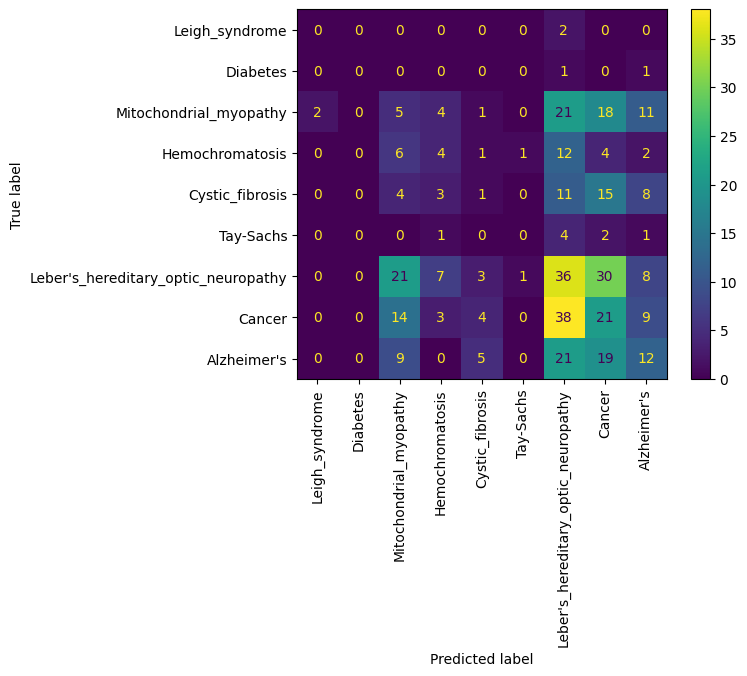

In [25]:
# Exibir a confusion matrix
y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = y.unique()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical')

In [26]:
# Configurando hiperparâmetros para o GridSearchCV do XGBoost para otimizar o modelo
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(subsample=0.9, colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)

optimal_params.fit(X_train, y_train)

print(optimal_params.best_params_)

c:\Users\mfppe\Documents\UFF 2024.2\Topicos em IA\Machine-Learning-for-Healthcare\venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\mfppe\Documents\UFF 2024.2\Topicos em IA\Machine-Learning-for-Healthcare\venv\lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}


c:\Users\mfppe\Documents\UFF 2024.2\Topicos em IA\Machine-Learning-for-Healthcare\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:05:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


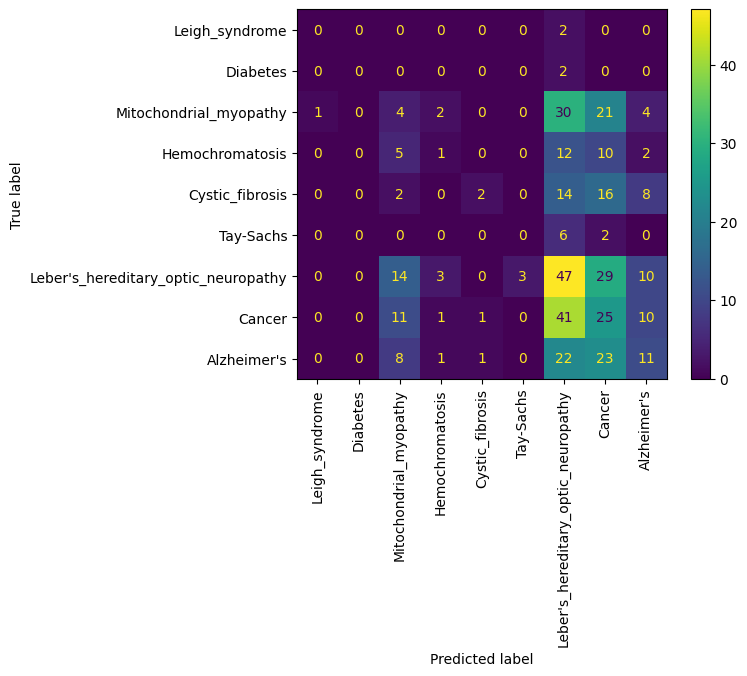

In [27]:
# Criando o modelo XGBoost preliminar
xgb_clf_opt = xgb.XGBClassifier(tree_method='hist', gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1)
xgb_clf_opt.fit(X_train, y_train)

# Exibir a confusion matrix
y_pred = xgb_clf_opt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = y.unique()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical')

c:\Users\mfppe\Documents\UFF 2024.2\Topicos em IA\Machine-Learning-for-Healthcare\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [00:10:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


weight:  {'mother_has_genetic_defect': 350.0, 'father_has_genetic_defect': 295.0, 'mothers_family_has_genetic_defect': 222.0, 'fathers_family_has_genetic_defect': 201.0, 'blood_cell_count': 1638.0, 'folic_acid_details': 134.0, 'history_of_pregnancy_complications': 109.0, 'history_of_radiation_exposure': 88.0, 'history_of_substance_abuse': 61.0, 'assisted_conception': 95.0, 'history_of_previous_pregnancy_anomaly': 149.0, 'num_of_previous_abortion': 339.0, 'multiple_birth_defects': 105.0, 'white_blood_cell_count': 1377.0, 'respiratory_rate_Normal_(30-60)': 88.0, 'heart_rate_Normal': 91.0, 'gender_Ambiguous': 101.0, 'gender_Female': 95.0, 'gender_Male': 86.0, 'blood_test_result_abnormal': 149.0, 'blood_test_result_inconclusive': 102.0, 'blood_test_result_normal': 62.0, 'blood_test_result_slightly_abnormal': 69.0}
gain:  {'mother_has_genetic_defect': 1.152989387512207, 'father_has_genetic_defect': 1.6358222961425781, 'mothers_family_has_genetic_defect': 1.7210264205932617, 'fathers_family_

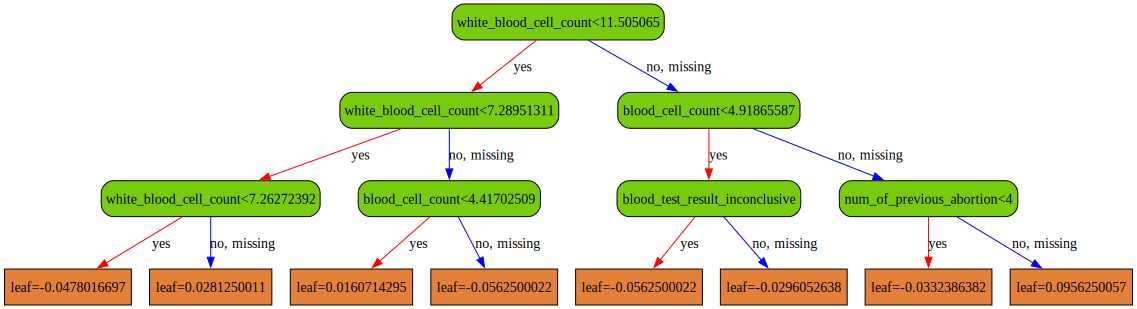

In [29]:
# Criando o modelo XGBoost preliminar
xgb_clf_opt_tree = xgb.XGBClassifier(tree_method='hist', gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=1)
xgb_clf_opt_tree.fit(X_train, y_train)

# Printar a XGBoost tree
bst = xgb_clf_opt_tree.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', 'style': 'filled, rounded', 'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box', 'style': 'filled', 'fillcolor': '#e48038'}

xgb.to_graphviz(xgb_clf_opt_tree, num_trees=0, size="10,10", condition_node_params=node_params, leaf_node_params=leaf_params)